# Intro

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
import seaborn

In [8]:
import pymannkendall as mk

In [9]:
from scipy.spatial.distance import cosine

In [10]:
import requests
import re
from bs4 import BeautifulSoup  # Per pulizia HTML nelle REST API

In [147]:
import datetime as dt

## Personal modules

In [12]:
from toolbox.updater import time_is_now

In [13]:
from file2text import file2text

In [14]:
from first_rough_cleaning import first_text_cleaner

In [15]:
from file_handler import *

In [16]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [17]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [18]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [19]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

## Witten's vector

In [20]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [21]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

## Load vectors

In [22]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [23]:
vecfiles.sort()

### Goals' vectors

#### Load files

In [24]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [25]:
goalvecfiles.sort()

In [26]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [27]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Reports' vectors

In [28]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [29]:
reports_files.sort()

In [30]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [31]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [32]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [33]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

## Sector helper

In [34]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [35]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [36]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

## SDG helper

In [37]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

# The Wikipedia benchmark

## Function

### get_wikipedia_texts: DeepSeek + Fabio

In [38]:
USER_AGENT = "YourProject/1.0 (your@email.com)"  # Obbligatorio per policy API

#### clean_wiki_text

In [69]:
def clean_wiki_text(text):
    # Rimozione sezioni indesiderate (bibliografia, note, etc.)
    text = re.sub(r'==\s*References\s*==.*|\=\=\s*Notes\s*\=\=.*|\=\=\s*External links\s*\=\=.*', '', text, flags=re.DOTALL)
    
    # Conversione markup Wiki -> Markdown
    text = re.sub(r"'''(.*?)'''", r"**\1**", text)  # Bold -> **bold**
    text = re.sub(r"''(.*?)''", r"*\1*", text)      # Italic -> *italic*
    
    # Rimozione complessa di template {{...}} e tag <...>
    text = re.sub(r'\{\{[^{}]*?\}\}|\<[^>]*?\>', '', text)
    
    # Pulizia link [[...]] -> mantiene solo testo ([[testo|alias]] -> testo)
    text = re.sub(r'\[\[([^|\]]+?)(?:\|.*?)?\]\]', r'\1', text)
    
    # Rimozione riferimenti [1], [2-3], etc.
    text = re.sub(r'\[\d+(?:\-\d+)?\]', '', text)
    
    # Normalizzazione spazi e newline
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = re.sub(r'[ \t]{2,}', ' ', text)
    
    return text.strip()

#### get_wikipedia_texts_v2

In [139]:
def get_wikipedia_texts_v2(rnlimit=100):
    base_url = "https://en.wikipedia.org/w/api.php"
    texts = []
    real_titles=[]
    # Step 1: Ottenere titoli casuali
    params_random = {
        "action": "query",
        "format": "json",
        "list": "random",
        "rnnamespace": 0,
        "rnlimit": rnlimit,
        "rnminsize": 6000,
        "rnmaxsize": 10000,
        "rnfilterredir": "nonredirects"
    }
    response_random = requests.get(base_url, params=params_random, headers={"User-Agent": USER_AGENT})
    titles = [item['title'] for item in response_random.json()['query']['random']]
    
    # Step 2: Scaricare contenuti con parsing HTML
    for title in titles:
        api_params = {
            "action": "parse",
            "page": title,
            "format": "json",
            "prop": "text",
            "disabletoc": 1
        }
        response = requests.get(base_url, params=api_params, headers={"User-Agent": USER_AGENT})
        
        if response.status_code == 200:
            html_content = response.json().get('parse', {}).get('text', {}).get('*', '')
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Rimozione elementi non testuali
            for element in soup.find_all(['table', 'sup', 'img', 'figure', 'style', 'script']):
                element.decompose()
            paragraphs = [p.get_text(separator=' ', strip=True) for p in soup.find_all('p')]
            full_text = "\n\n".join([p for p in paragraphs if len(p.split()) > 1])
            
            # Filtro finale sulla lunghezza (1000-1500 parole)
            #word_count = len(full_text.split())
            #if 1000 <= word_count <= 1500:
            ftc=first_text_cleaner(clean_wiki_text(full_text))
            texts.append(ftc)
            real_titles.append(title)
    return real_titles, texts

## How long have to be the benchmark's texts?

In [41]:
pdfs=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.pdf')]
pdfs.sort()

In [42]:
pdfs

['Goal-10-Fast-Facts.pdf',
 'Goal-11_Fast-Facts.pdf',
 'Goal-12_Fast-Facts.pdf',
 'Goal-13_Fast-Facts.pdf',
 'Goal-14_Fast-Facts.pdf',
 'Goal-15-Fast-Facts.pdf',
 'Goal-16-Fast-Facts.pdf',
 'Goal-17-Fast-Facts.pdf',
 'Goal-1_Fast-Facts.pdf',
 'Goal-2_Fast-Facts.pdf',
 'Goal-3_Fast-Facts.pdf',
 'Goal-4_Fast-Facts.pdf',
 'Goal-5_Fast-Facts.pdf',
 'Goal-6_Fast-Facts.pdf',
 'Goal-7_Fast-Facts.pdf',
 'Goal-8_Fast-Facts.pdf',
 'Goal-9-Fast-Facts.pdf',
 'Goal-Fast-Facts.pdf',
 'Witten_A_Mini_Introduction_To_Information_Theory.pdf']

In [43]:
l_benchs=[]
for i_pdf, pdf in enumerate(tqdm(pdfs)):
    # vector file name
    vecfile=pdf.replace('.pdf', '.txt')
    # get the md file name
    file_name_md=pdf.replace('.pdf', '.md')
    # read the md file
    with open(BENCHMARK_FOLDER+file_name_md, 'r') as f:
        markdown_string = f.read()
    l_benchs.append(len(first_text_cleaner(markdown_string)))

  0%|          | 0/19 [00:00<?, ?it/s]

In [44]:
min(l_benchs), max(l_benchs[:-2])

(3533, 4639)

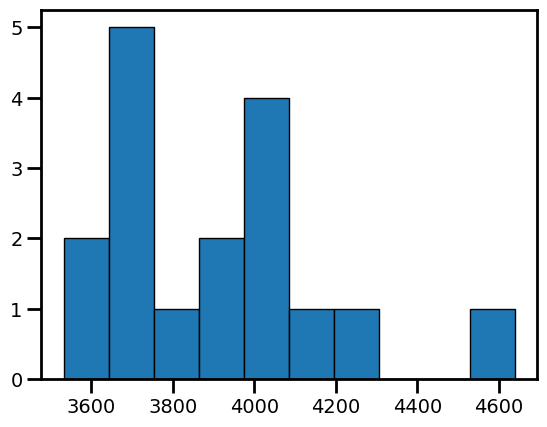

In [45]:
plt.hist(l_benchs[:-2], edgecolor='black')
plt.show()

In [51]:
min_lenght=3000
max_lenght=5000

## Run

In [43]:
min_lenght=3000
max_lenght=5000

Let it run in bunches:

In [40]:
th=4000

In [153]:
titles=[]
texts=[]
_round=0
while len(titles)<th:
    _titles, _texts = get_wikipedia_texts_v2(500)
    for i_t, _text in enumerate(_texts): 
        if len(_text)>=min_lenght and len(_text)<=max_lenght:
            texts.append(_text)
            titles.append(_titles[i_t])
    print(f'[{dt.datetime.now():%H:%M:%S}] round={_round:4}, len(titles)={len(titles):4}')
    _round+=1

[14:12:23] round=   0, len(titles)=   0
[14:16:27] round=   1, len(titles)= 126
[14:20:27] round=   2, len(titles)= 258
[14:24:25] round=   3, len(titles)= 384
[14:28:29] round=   4, len(titles)= 520
[14:32:34] round=   5, len(titles)= 660
[14:36:41] round=   6, len(titles)= 793
[14:40:45] round=   7, len(titles)= 928
[14:44:57] round=   8, len(titles)=1066
[14:49:01] round=   9, len(titles)=1184
[14:53:11] round=  10, len(titles)=1307
[14:57:22] round=  11, len(titles)=1446
[15:01:28] round=  12, len(titles)=1578
[15:05:35] round=  13, len(titles)=1698
[15:09:52] round=  14, len(titles)=1832
[15:14:06] round=  15, len(titles)=1962
[15:18:14] round=  16, len(titles)=2099
[15:22:19] round=  17, len(titles)=2246
[15:26:23] round=  18, len(titles)=2377
[15:30:36] round=  19, len(titles)=2510
[15:34:43] round=  20, len(titles)=2647
[15:39:04] round=  21, len(titles)=2771
[15:43:08] round=  22, len(titles)=2902
[15:47:07] round=  23, len(titles)=3038
[15:51:23] round=  24, len(titles)=3164


### Save texts

In [159]:
def title2filename(counter, title):
    return 'wikipedia_'+str(counter).zfill(4)+'_'+'_'.join(title.replace('/', '_').split(' '))+'.txt'

In [162]:
for i_t, title in enumerate(tqdm(titles)):
    file_name=title2filename(i_t, title).replace('.txt', '_text.txt')
    with open(BENCHMARK_FOLDER+file_name, 'w') as f:
        f.write(texts[i_t])

  0%|          | 0/4001 [00:00<?, ?it/s]

# Embed texts

In [ ]:
for i_t, title in enumerate(titles):
    print(f'[{dt.datetime.now():%H:%M:%S}] {i_t:4}) title={title:20}')
    sys.stdout.flush()
    file_name=title2filename(i_t, title)
    vec=jina4lote(texts[i_t])
    np.savetxt(BENCHMARK_FOLDER+file_name, vec)

[17:43:00]    0) title=Kalmar Castle       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:07]    1) title=Fertility and religion


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:13]    2) title=Kadant              


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:18]    3) title=James Tomkovicz     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:24]    4) title=Nauru Phosphate Royalties Trust


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:27]    5) title=The Life of a Useless Man


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:34]    6) title=Plum curculio       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:39]    7) title=Carl Pfeiffer (pharmacologist)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:44]    8) title=Melanitis phedima   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:50]    9) title=John E. Erickson (Montana politician)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:54]   10) title=Keating Hall        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:43:58]   11) title=Sachs–Wolfe effect  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:04]   12) title=Asa Singh Mastana   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:08]   13) title=Steve Hollenhorst   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:15]   14) title=The Crucible (opera)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:20]   15) title=Slices of Life (2010 film)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:26]   16) title=Powder River Station-Powder River Crossing


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:35]   17) title=Dungeon Planner Set 2: Nightmare in Blackmarsh


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:41]   18) title=OpenVanilla         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:49]   19) title=The Walls of Jericho (canyon)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:53]   20) title=Bankhar Dog         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:44:58]   21) title=Jamie White         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:05]   22) title=John Q. Trojanowski 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:10]   23) title=Welding Procedure Specification


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:16]   24) title=Glut: Mastering Information Through the Ages


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:21]   25) title=Eric T. Huddleston  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:26]   26) title=Eugene Lockhart     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:35]   27) title=Occupant (film)     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:42]   28) title=Multiple encryption 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:50]   29) title=John P. Saylor Trail


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:55]   30) title=1945–46 in Scottish football


  0%|          | 0/1 [00:00<?, ?it/s]

[17:45:59]   31) title=Letter of the Twenty Five


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:06]   32) title=Ron Hodgson Motors  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:11]   33) title=Kamaljit Bawa       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:17]   34) title=Superior laryngeal nerve


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:23]   35) title=Hylaecullulus       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:31]   36) title=Antelope (1780 packet)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:37]   37) title=Guatemala Quetzal Rugby Club


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:41]   38) title=Peggy Fowler        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:46]   39) title=Maurice Glaize      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:54]   40) title=Miss Mend           


  0%|          | 0/1 [00:00<?, ?it/s]

[17:46:59]   41) title=V. G. Bhide         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:03]   42) title=Minju Joson         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:11]   43) title=Daud Shah Bahmani   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:19]   44) title=Languages of Austria


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:25]   45) title=James Robins        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:29]   46) title=Bill Sweetenham     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:33]   47) title=Institute of Philosophy, University of Warsaw


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:40]   48) title=Détente (band)      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:45]   49) title=Liscartan           


  0%|          | 0/1 [00:00<?, ?it/s]

[17:47:53]   50) title=The Vertical Hour   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:00]   51) title=Christopher Newton  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:06]   52) title=Nancy Oestreich Lurie


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:15]   53) title=Arvind Raturi       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:22]   54) title=La vida breve (opera)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:28]   55) title=Astro Warrior       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:32]   56) title=Secret Valley       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:38]   57) title=Baku during World War II


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:43]   58) title=Bully's Acre, Dublin


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:49]   59) title=WRVF                


  0%|          | 0/1 [00:00<?, ?it/s]

[17:48:57]   60) title=Central Mexican matorral


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:06]   61) title=Dargaville Branch   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:11]   62) title=Administrator, Transvaal v Theletsane


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:18]   63) title=Vishnudas Bhave     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:26]   64) title=MLS Re-Entry Draft  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:32]   65) title=Craigieburn Road    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:38]   66) title=Abu Hassan          


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:43]   67) title=AB Flygindustri Fi-1


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:48]   68) title=Charybdis longicollis


  0%|          | 0/1 [00:00<?, ?it/s]

[17:49:53]   69) title=Hans Bethge (aviator)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:00]   70) title=Eugenia dysenterica 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:05]   71) title=William Wycliffe Spooner


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:12]   72) title=Bavarian cream      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:17]   73) title=Henry Septimus Sutton


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:21]   74) title=Messa di voce       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:28]   75) title=Redlynch, Somerset  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:38]   76) title=Thomas Eastchurch   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:44]   77) title=Saloon (band)       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:50]   78) title=McPike Mansion      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:53]   79) title=Adwell              


  0%|          | 0/1 [00:00<?, ?it/s]

[17:50:57]   80) title=Mom's the Word      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:04]   81) title=1874–75 Scottish Districts season


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:11]   82) title=In Deadly Earnest   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:16]   83) title=Emmanuel Ondo Methogo


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:20]   84) title=IS-1 Sęp            


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:29]   85) title=Mary B. Warlick     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:34]   86) title=Israeli Beach Soccer League


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:41]   87) title=Kazimierz Cichowski 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:46]   88) title=Long Creek, Illinois


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:52]   89) title=USS Raby            


  0%|          | 0/1 [00:00<?, ?it/s]

[17:51:59]   90) title=Jakarta Flood Canal 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:04]   91) title=Port of Caen        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:11]   92) title=Integrated framing assembly


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:14]   93) title=John Barry (WD-40)  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:20]   94) title=Elm Conflict        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:25]   95) title=Hajime Ishii        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:30]   96) title=Meitei architecture 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:37]   97) title=Daniël Boone        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:42]   98) title=Take It Out in Trade


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:47]   99) title=Matthew 7:10        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:52]  100) title=National Army Museum (New Zealand)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:52:59]  101) title=Jiří Melantrich of Aventino


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:09]  102) title=Randy Souders       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:14]  103) title=Rosalie Abrams      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:21]  104) title=Susannah Waters     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:26]  105) title=Mary Cole Walling   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:30]  106) title=Joachim Rampon      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:37]  107) title=Sadko (film)        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:44]  108) title=K. Gordon Murray    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:50]  109) title=Tony Saunders       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:55]  110) title=Ryan Martin (athlete)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:53:59]  111) title=Lucy G. Acosta      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:03]  112) title=Leinkupal           


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:10]  113) title=Speedway Super Prix 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:13]  114) title=Wilf McGuinness     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:18]  115) title=Juan Nepomuceno Zegrí Moreno


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:23]  116) title=Jacob M. Dickinson  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:26]  117) title=Lords of Regality   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:32]  118) title=David Earn          


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:36]  119) title=Jubilee Medal "50 Years of Victory in the Great Patriotic War 1941–1945"


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:41]  120) title=Sainte-Anne-d'Auray 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:48]  121) title=Napoleon Murphy Brock


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:53]  122) title=The Reckoning (2014 film)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:54:58]  123) title=Sergey Urusevsky    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:04]  124) title=Republic of Mountainous Armenia


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:10]  125) title=Vatican City at the 2022 Mediterranean Games


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:15]  126) title=Pietra Perduca      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:21]  127) title=Clarence F. Stephens


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:27]  128) title=First Quench Retailing


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:32]  129) title=Western concert flute family


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:42]  130) title=6th Congress of the Party of Labour of Albania


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:51]  131) title=Luxembourg in the Eurovision Song Contest 1989


  0%|          | 0/1 [00:00<?, ?it/s]

[17:55:56]  132) title=John Sampson (musician)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:01]  133) title=Peng Shaohui        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:10]  134) title=False Profits       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:16]  135) title=Ray David Owen      


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:24]  136) title=Unfinished Pyramid of Abusir


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:31]  137) title=Utah State Route 199


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:36]  138) title=Thomas Mercer       


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:44]  139) title=Homodyne detection  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:49]  140) title=Ivo Sajh            


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:54]  141) title=HLB International   


  0%|          | 0/1 [00:00<?, ?it/s]

[17:56:59]  142) title=Onehunga Blockhouse 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:04]  143) title=School Number 6 (Davenport, Iowa)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:11]  144) title=Mary Caffrey Low    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:20]  145) title=Jackie Vernon (comedian)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:28]  146) title=Benno Kusche        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:35]  147) title=Eric Williams (writer)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:43]  148) title=Arene lychee        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:51]  149) title=Clive Barker (artist, born 1940)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:57:57]  150) title=Yn Çheshaght Ghailckagh


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:02]  151) title=Bristol 404 and 405 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:08]  152) title=Coup d'État: A Practical Handbook


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:13]  153) title=War Tapes           


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:22]  154) title=Tyrone Square Mall  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:26]  155) title=Detroit Athletic Club


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:32]  156) title=Axiom of pairing    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:39]  157) title=The Delivery Boy (1931 film)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:44]  158) title=Helen L. Thomas     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:48]  159) title=Uauá                


  0%|          | 0/1 [00:00<?, ?it/s]

[17:58:54]  160) title=Syro-Malabar Catholic Eparchy of Irinjalakuda


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:03]  161) title=Hansol              


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:11]  162) title=J. D. Mooney        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:16]  163) title=Daniel Dromm        


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:20]  164) title=Simon Fitz-Richard  


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:27]  165) title=Catherine Croft     


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:34]  166) title=Marguerite Steen    


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:40]  167) title=Ede Herczog         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:44]  168) title=Eretz Israel Museum 


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:48]  169) title=Jazz Bridge         


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:52]  170) title=Headline Hunters (1945 film)


  0%|          | 0/1 [00:00<?, ?it/s]

[17:59:56]  171) title=Little Grassy Lake (Illinois)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:01]  172) title=Arcot Hall Grasslands and Ponds


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:06]  173) title=Warid Bangladesh    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:11]  174) title=Pyeonsu             


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:17]  175) title=George Seeman       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:21]  176) title=Thibault Daubagna   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:28]  177) title=Habib Essid         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:32]  178) title=Italian destroyer Alfredo Oriani


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:38]  179) title=Kris Defoort        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:45]  180) title=The Darwin Awards (film)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:50]  181) title=Doctor Sally        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:00:59]  182) title=Raffi Lavie         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:04]  183) title=Joseph Hallman      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:10]  184) title=Haliotis corrugata  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:16]  185) title=USS Flint (AE-32)   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:20]  186) title=Kankuamo marquezi   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:30]  187) title=Arthur Underhill    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:37]  188) title=Camp Toccoa         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:43]  189) title=Amorgos oil spill   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:49]  190) title=Vladimir Homan      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:54]  191) title=Transcontinental Airway System


  0%|          | 0/1 [00:00<?, ?it/s]

[18:01:58]  192) title=Birdlings Flat      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:04]  193) title=Bautzen II          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:10]  194) title=St. Catherine's Church, Hamburg


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:17]  195) title=The Letter Left to Me


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:21]  196) title=Vail Airport, Montebello


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:27]  197) title=Christ in Glory in the Tetramorph


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:35]  198) title=Jusuf Muda Dalam    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:41]  199) title=Richard Lumley, 12th Earl of Scarbrough


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:45]  200) title=Cranberry sauce     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:49]  201) title=Ryuya Matsumoto     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:02:53]  202) title=Series–parallel graph


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:00]  203) title=The Magus (film)    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:07]  204) title=Nancy Ostrander     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:13]  205) title=Clemons, Iowa       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:23]  206) title=HMS Cracker (1804)  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:28]  207) title=Myosotis pottsiana  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:36]  208) title=Euglossa mixta      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:41]  209) title=Aisha Abd al-Rahman 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:45]  210) title=Amos Fortune        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:03:54]  211) title=The Last of Philip Banter (film)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:01]  212) title=American University of Integrative Sciences


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:07]  213) title=Vusi Mahlasela      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:12]  214) title=Movimento Democrático de Mulheres


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:19]  215) title=Tsutsumi Hōzan-ryū  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:28]  216) title=ContraPest          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:33]  217) title=Aboud El Zomor      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:40]  218) title=Bertha Zúñiga       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:46]  219) title=Siemensstadt-Fürstenbrunn station


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:52]  220) title=Misan Sagay         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:04:56]  221) title=Royal Prussian Military Railway


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:04]  222) title=Franz Michael Felder


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:11]  223) title=Whitehead manifold  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:25]  224) title=Karlag              


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:31]  225) title=Elly M. Peterson    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:36]  226) title=Dallas Hodge        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:42]  227) title=Mynydd Llangatwg    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:52]  228) title=Pedro de Tovar      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:05:58]  229) title=Dennis King (author)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:01]  230) title=Oliver Golden       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:05]  231) title=Marcus Clark & Co.  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:09]  232) title=Tulip Time Festival 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:14]  233) title=Albert Fink         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:19]  234) title=James Charles Macnab of Macnab


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:24]  235) title=William Brown (ship)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:30]  236) title=Abdul Jamil Shah I of Pahang


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:40]  237) title=Cyrus Peirce        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:48]  238) title=HMS M33             


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:54]  239) title=Swamp pink (magazine)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:06:59]  240) title=Donald Keith McDowell


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:03]  241) title=Expecting (film)    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:11]  242) title=William of Breteuil 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:15]  243) title=Ben Sonnenberg      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:22]  244) title=Arthur Kramer       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:29]  245) title=Churchill Rocket Research Range


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:33]  246) title=Aviation boatswain's mate


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:38]  247) title=Terry Aulich        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:44]  248) title=Erotas season 1     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:49]  249) title=Yarigu Helbedi      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:07:56]  250) title=Art Donahue         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:01]  251) title=Mysterious (horse)  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:06]  252) title=SV Nominoé (1886)   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:11]  253) title=Charlie Cullinane   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:18]  254) title=The Thief (Turner novel)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:26]  255) title=Manchester Association F.C.


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:32]  256) title=Come Along and Walk with Me


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:37]  257) title=HMS Minerva (1895)  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:41]  258) title=Botany Bay (film)   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:48]  259) title=Ludic interface     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:08:54]  260) title=Mississippi embayment


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:00]  261) title=Pfalzfeld           


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:09]  262) title=Fort St. George (Thomaston, Maine)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:13]  263) title=Missile Gap         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:19]  264) title=Thirumayam          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:28]  265) title=Daffy Duck: The Marvin Missions


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:35]  266) title=Pont y Werin        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:40]  267) title=Beth Israel Synagogue (Hamilton, Ohio)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:44]  268) title=Battle of Niså      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:48]  269) title=Tau (film)          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:55]  270) title=NFL Night Series    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:09:59]  271) title=H. H. Abbott        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:04]  272) title=Christian IV's Arsenal


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:09]  273) title=M. P. Jayaraj       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:16]  274) title=First Exhibition (1760)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:21]  275) title=Stefan de Walden    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:28]  276) title=Zoltán Kovac (footballer, born 1954)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:35]  277) title=Andrew Pavlovsky    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:45]  278) title=Bob Pearce          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:10:52]  279) title=The Spy Who Learned Me


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:00]  280) title=WVTX-CD             


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:05]  281) title=Stanisław Małachowski


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:13]  282) title=Samuel Owen (engineer)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:19]  283) title=Liquor Control Act 1988


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:23]  284) title=ATP-binding domain of ABC transporters


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:28]  285) title=Warrulan            


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:34]  286) title=Aalst Chocolate     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:38]  287) title=Huka Entertainment  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:45]  288) title=Ludovick Duncombe-Jewell Cameron


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:49]  289) title=Study Bible         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:52]  290) title=American Council of Witches


  0%|          | 0/1 [00:00<?, ?it/s]

[18:11:56]  291) title=Lifuka Island Airport


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:02]  292) title=Palazzo Madama, Turin


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:10]  293) title=Montereau-Fault-Yonne


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:16]  294) title=2009 Armed Forces Bowl


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:20]  295) title=Glossogobius ankaranensis


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:25]  296) title=Kolahoi Peak        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:30]  297) title=SS Jane Miller      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:36]  298) title=BR Standard Class 4 2-6-0 76084


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:42]  299) title=Rafael María de Aguilar y Ponce de León


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:46]  300) title=The Christmas Raccoons


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:51]  301) title=T-bone steak        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:12:58]  302) title=Odd F. Lindberg     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:03]  303) title=Denis Mann          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:08]  304) title=Codru, Moldova      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:13]  305) title=Greater Goiânia     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:18]  306) title=The Encounter (2011 film)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:22]  307) title=Snyder, Nebraska    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:28]  308) title=Carrillo family of California


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:34]  309) title=Kate Brousseau      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:41]  310) title=(Turn On) The Music Machine


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:48]  311) title=Arthur M. Young     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:54]  312) title=Caesars Head State Park


  0%|          | 0/1 [00:00<?, ?it/s]

[18:13:59]  313) title=The Velaires        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:04]  314) title=Edith Wilson (singer)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:10]  315) title=British Society of Urogynaecology


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:15]  316) title=The Three Clever Kings


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:24]  317) title=1948 Nauru riots    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:29]  318) title=Jerviston           


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:34]  319) title=Solar eclipse of September 4, 2100


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:41]  320) title=Shelly Beach (Manly)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:47]  321) title=David Yonggi Cho    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:52]  322) title=Mastery (horse)     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:14:56]  323) title=Richard Becker (music publisher)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:02]  324) title=Layer Road          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:06]  325) title=Leienfels Castle    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:11]  326) title=Karl Schembri       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:17]  327) title=Khlong Samrong      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:27]  328) title=Falcon Ridge Folk Festival


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:31]  329) title=Ludo Martens        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:37]  330) title=Edith McAllister    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:44]  331) title=Tallahassee Democrat


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:49]  332) title=Theologia Poetica   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:15:56]  333) title=MacPherson Presbyterian Church


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:01]  334) title=Margaret Gurney     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:05]  335) title=Sofia Kuvshinnikova 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:11]  336) title=F-scale (personality test)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:15]  337) title=Moral waiver        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:20]  338) title=East Saltoun and West Saltoun


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:24]  339) title=Richard Kaden       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:31]  340) title=Sonnet 17           


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:36]  341) title=Galo Plaza          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:44]  342) title=Frances Dias        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:48]  343) title=Kerala Financial Corporation


  0%|          | 0/1 [00:00<?, ?it/s]

[18:16:53]  344) title=Samba (bank)        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:00]  345) title=Warner Parks        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:08]  346) title=Andrew Buckland (playwright)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:13]  347) title=Czech Science Foundation


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:18]  348) title=Green Star (Australia)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:23]  349) title=Bayes linear statistics


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:30]  350) title=Richard Heslop (director)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:36]  351) title=12th Mississippi Infantry Regiment


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:42]  352) title=Circassians in Kosovo


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:46]  353) title=Baltic knighthoods  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:17:52]  354) title=Abdulcelil Levni    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:01]  355) title=Thirupullabhoothangudi Temple


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:09]  356) title=Dih (archaeology)   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:17]  357) title=Orhuwhorun          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:26]  358) title=Geneva Observatory  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:31]  359) title=Milan Lukač         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:36]  360) title=Abe Greenthal       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:41]  361) title=Colin Eaborn        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:48]  362) title=10th Infantry Brigade (New Zealand)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:53]  363) title=Jacob Aldolphus Bryce


  0%|          | 0/1 [00:00<?, ?it/s]

[18:18:58]  364) title=Ariadna Shengelaya  


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:07]  365) title=Yelverton Inn and Store


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:13]  366) title=Peter Krogh (photographer)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:19]  367) title=Hilbert's fifteenth problem


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:23]  368) title=Dany Roland         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:28]  369) title=Tubac Presidio State Historic Park


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:36]  370) title=Mary Hutcheson Page 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:43]  371) title=Claire Bennet       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:48]  372) title=Mary Smith Lockwood 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:54]  373) title=Tarleton Academy    


  0%|          | 0/1 [00:00<?, ?it/s]

[18:19:58]  374) title=The Squire's Tale   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:05]  375) title=Thomas Anselmi      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:11]  376) title=Pilottown, Louisiana


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:17]  377) title=Lucien Laberthonnière


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:23]  378) title=Majorinus           


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:29]  379) title=The New Mother      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:36]  380) title=Gelation            


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:46]  381) title=West Dover, Nova Scotia


  0%|          | 0/1 [00:00<?, ?it/s]

[18:20:54]  382) title=Louis Navellier     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:03]  383) title=Bitter Spring (San Bernardino County)


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:12]  384) title=Asia (magazine)     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:17]  385) title=MH Message Handling System


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:23]  386) title=Field Trip (band)   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:28]  387) title=Takase River        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:38]  388) title=Catholic University Cardinals rowing


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:45]  389) title=Nick Reynolds       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:53]  390) title=Dave Aron           


  0%|          | 0/1 [00:00<?, ?it/s]

[18:21:57]  391) title=Revaz Chomakhidze   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:03]  392) title=Yilma Deressa       


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:08]  393) title=Your Friend the Rat 


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:15]  394) title=EFF DES cracker     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:24]  395) title=Patricia McIlrath   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:28]  396) title=Megan Marshack      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:32]  397) title=Max Gluckman        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:37]  398) title=Susana Naidich      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:41]  399) title=1978 Nobel Prize in Literature


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:47]  400) title=Peter Beet          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:53]  401) title=Iván Argote         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:22:58]  402) title=Blueschist          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:06]  403) title=Helen Copenhaver Hanes


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:11]  404) title=Naceur Ben Jaâfar   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:18]  405) title=Vietnam Day Committee


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:23]  406) title=Statutory citizenship


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:28]  407) title=Yuno Avshalumov     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:36]  408) title=Lee Sing-man        


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:43]  409) title=York Flour Mill     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:50]  410) title=Chihaya Adachi      


  0%|          | 0/1 [00:00<?, ?it/s]

[18:23:54]  411) title=Beijing U7          


  0%|          | 0/1 [00:00<?, ?it/s]

[18:24:01]  412) title=Old Bank Arcade     


  0%|          | 0/1 [00:00<?, ?it/s]

[18:24:05]  413) title=Dorothy Fay         


  0%|          | 0/1 [00:00<?, ?it/s]

[18:24:11]  414) title=Regular embedding   


  0%|          | 0/1 [00:00<?, ?it/s]

[18:24:27]  415) title=Xu Ci               


  0%|          | 0/1 [00:00<?, ?it/s]

[18:24:35]  416) title=Baarìa (film)       


  0%|          | 0/1 [00:00<?, ?it/s]

Now, go back to the PCA reduction of everything...